In [1]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install torch torchvision numpy matplotlib scikit-learn scipy
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MeanSquaredError
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn.functional as F
import torch_fidelity
import shutil
from PIL import Image
import glob
import random
import os
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch_fidelity
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [18]:
class ResNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_blocks=9):
        super(ResNetGenerator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 7, padding=3, padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Downsampling: 64→16 (two stride-2 convs: 64→32→16)
        self.down = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(256)
            ) for _ in range(num_blocks)
        ])
        
        # Upsampling: 16→128 (three stride-2 convs: 16→32→64→128)
        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling for HR→LR: 32→64 (after down: 128→32)
        self.down_for_hr = nn.Sequential(
            nn.Conv2d(256, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv_out = nn.Conv2d(64, out_channels, 7, padding=3, padding_mode='reflect')
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        assert x.shape[1] == 1, f"Expected 1 input channel, got {x.shape[1]}"
        assert x.shape[2] in [64, 128], f"Expected spatial size 64 or 128, got {x.shape[2]}"
        
        # Initial conv
        out = self.conv1(x)
        assert out.shape[1] == 64, f"After conv1, expected 64 channels, got {out.shape[1]}"
        assert out.shape[2] == x.shape[2], f"After conv1, expected spatial size {x.shape[2]}, got {out.shape[2]}"
        
        out = self.bn1(out)
        out = self.relu(out)
        
        # Downsampling
        out = self.down(out)
        expected_down_size = 16 if x.shape[2] == 64 else 32
        assert out.shape[1] == 256, f"After down, expected 256 channels, got {out.shape[1]}"
        assert out.shape[2] == expected_down_size, f"After down, expected spatial size {expected_down_size}, got {out.shape[2]}"
        
        # Residual blocks
        for block in self.res_blocks:
            residual = out
            assert out.shape[1] == 256, f"Before res_block, expected 256 channels, got {out.shape[1]}"
            out = block(out)
            assert out.shape[1] == 256, f"After res_block, expected 256 channels, got {out.shape[1]}"
            assert out.shape[2] == expected_down_size, f"After res_block, expected spatial size {expected_down_size}, got {out.shape[2]}"
            out = out + residual
        
        # Upsampling for LR→HR
        if x.shape[2] == 64:
            out = self.up(out)
            out = F.interpolate(out, size=(128, 128), mode='bilinear', align_corners=False)
            assert out.shape[1] == 64, f"After up, expected 64 channels, got {out.shape[1]}"
            assert out.shape[2] == 128, f"After up, expected spatial size 128, got {out.shape[2]}"
        
        # Channel reduction for HR→LR
        if x.shape[2] == 128:
            out = self.down_for_hr(out)
            assert out.shape[1] == 64, f"After down_for_hr, expected 64 channels, got {out.shape[1]}"
        
        # Output
        out = self.conv_out(out)
        assert out.shape[1] == 1, f"After conv_out, expected 1 channel, got {out.shape[1]}"
        
        # Downsample for HR→LR
        if x.shape[2] == 128:
            out = F.interpolate(out, size=(64, 64), mode='bilinear', align_corners=False)
            assert out.shape[2] == 64, f"After HR downsample, expected spatial size 64, got {out.shape[2]}"
        
        out = self.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),  # 128→64 or 64→32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),          # 64→32 or 32→16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),         # 32→16 or 16→8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=1, padding=2),         # 16→17 or 8→9
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)            # 17→16 or 9→8
        )
    
    def forward(self, x):
        assert x.shape[2] in [64, 128], f"Expected spatial size 64 or 128, got {x.shape[2]}"
        out = self.model(x)
        expected_size = 8 if x.shape[2] == 64 else 16
        assert out.shape[2] == expected_size, f"Expected output spatial size {expected_size}, got {out.shape[2]}"
        return out
        
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:29].eval()
        self.vgg = vgg.to("cuda")
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse = nn.MSELoss()
    
    def forward(self, x, y):
        x = x.repeat(1, 3, 1, 1)
        y = y.repeat(1, 3, 1, 1)
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.mse(x_features, y_features)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
G_A = ResNetGenerator().to(device)  # LR→HR
G_B = ResNetGenerator().to(device)  # HR→LR
D_A = Discriminator().to(device)    # HR discriminator
D_B = Discriminator().to(device)    # LR discriminator


adversarial_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()
vgg_criterion = PerceptualLoss()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 232MB/s] 


In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
real_lr_dir = "/kaggle/input/image-super-resolution-3b/Dataset/LR"
real_hr_dir = "/kaggle/input/image-super-resolution-3b/Dataset/HR"

Sample: 1
LR Image Shape: (1, 64, 64), HR Image Shape: (1, 128, 128)
LR Image Min: -0.0044, Max: 0.9987
HR Image Min: 0.0019, Max: 1.0108



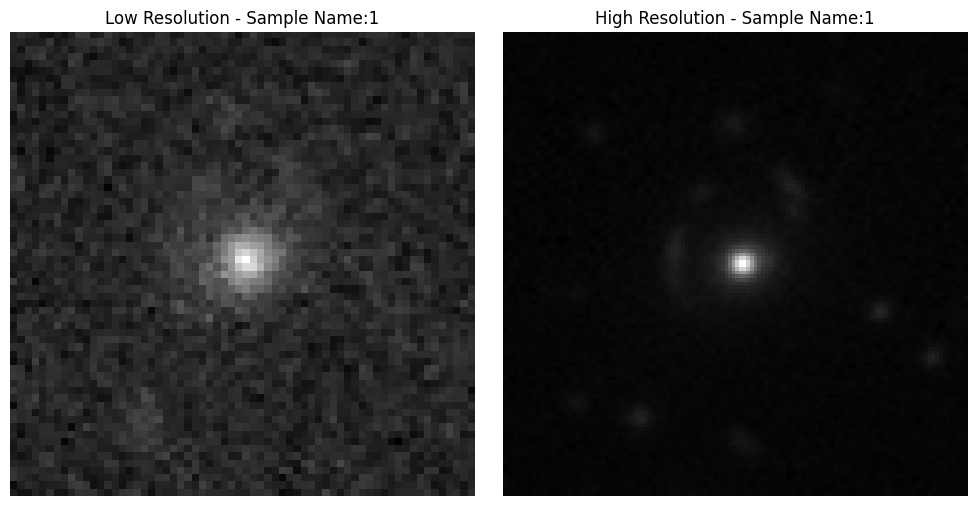

Sample: 10
LR Image Shape: (1, 64, 64), HR Image Shape: (1, 128, 128)
LR Image Min: 0.0043, Max: 0.9869
HR Image Min: 0.0010, Max: 1.0055



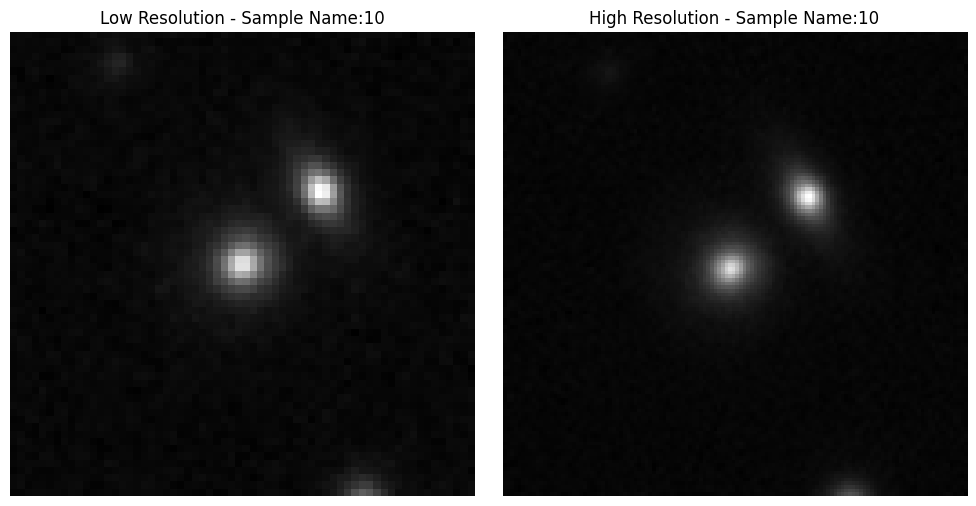

Sample: 100
LR Image Shape: (1, 64, 64), HR Image Shape: (1, 128, 128)
LR Image Min: 0.0018, Max: 0.9976
HR Image Min: 0.0001, Max: 1.0202



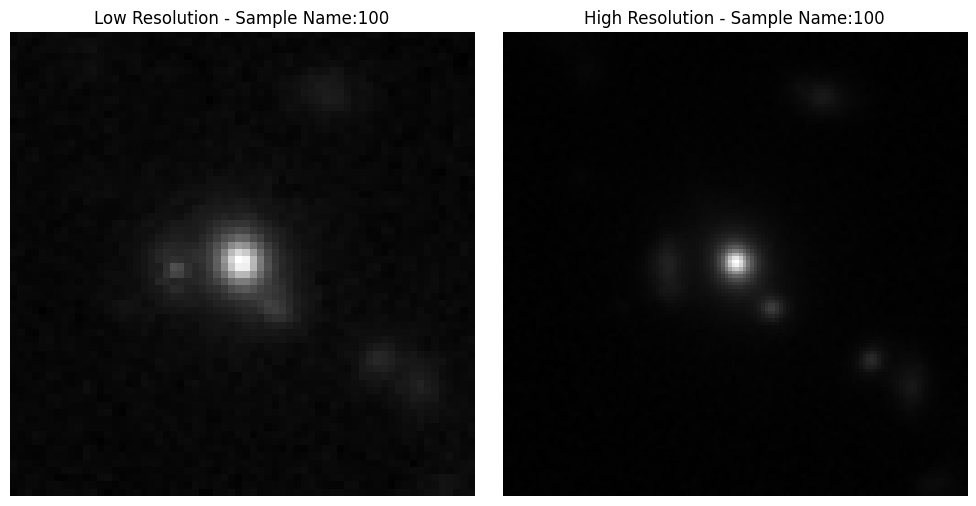

In [22]:
def load_npy_file(filepath):
    return np.load(filepath)

def visualize_image_pairs(lr_image, hr_image, sample_name):
    if lr_image.ndim == 3 and lr_image.shape[0] == 1:
        lr_image = lr_image[0]
    if hr_image.ndim == 3 and hr_image.shape[0] == 1:
        hr_image = hr_image[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(lr_image, cmap='gray')
    axes[0].set_title(f"Low Resolution - {sample_name}")
    axes[0].axis('off')
    
    axes[1].imshow(hr_image, cmap='gray')
    axes[1].set_title(f"High Resolution - {sample_name}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

sample_ids = ["1", "10", "100"]

for sample_id in sample_ids:
    lr_path = os.path.join(real_lr_dir, f"LR_{sample_id}.npy")
    hr_path = os.path.join(real_hr_dir, f"HR_{sample_id}.npy")
    
    if os.path.exists(lr_path) and os.path.exists(hr_path):
        lr_image = load_npy_file(lr_path)
        hr_image = load_npy_file(hr_path)
        
        print(f"Sample: {sample_id}")
        print(f"LR Image Shape: {lr_image.shape}, HR Image Shape: {hr_image.shape}")
        print(f"LR Image Min: {lr_image.min():.4f}, Max: {lr_image.max():.4f}")
        print(f"HR Image Min: {hr_image.min():.4f}, Max: {hr_image.max():.4f}\n")
        
        visualize_image_pairs(lr_image, hr_image, f"Sample Name:{sample_id}")
    else:
        print(f"Files for {sample_id} not found. Check paths: {lr_path}, {hr_path}")

In [23]:
class RealLensingDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_files = sorted([f for f in os.listdir(lr_dir) if f.endswith('.npy')])
        self.hr_files = sorted([f for f in os.listdir(hr_dir) if f.endswith('.npy')])
        assert len(self.lr_files) == len(self.hr_files), "Mismatch in LR and HR file counts"
        self.transform = transform
    
    def __len__(self):
        return len(self.lr_files)
    
    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        
        lr_img = np.load(lr_path)
        hr_img = np.load(hr_path)
        
        lr_img = lr_img.astype(np.float32)
        hr_img = hr_img.astype(np.float32)
        
        if lr_img.ndim == 3 and lr_img.shape[0] == 1:
            lr_img = lr_img.squeeze(0)
        if hr_img.ndim == 3 and hr_img.shape[0] == 1:
            hr_img = hr_img.squeeze(0)
        
        assert lr_img.shape == (64, 64), f"Expected LR shape (64, 64), got {lr_img.shape}"
        assert hr_img.shape == (128, 128), f"Expected HR shape (128, 128), got {hr_img.shape}"
        
        # Clamp to [0, 1]
        lr_img = np.clip(lr_img, 0, 1)
        hr_img = np.clip(hr_img, 0, 1)
        
        lr_img = torch.from_numpy(lr_img).unsqueeze(0)
        hr_img = torch.from_numpy(hr_img).unsqueeze(0)
        
        if self.transform:
            seed = np.random.randint(2147483647)  
            torch.manual_seed(seed)
            lr_img = self.transform(lr_img)
            torch.manual_seed(seed)
            hr_img = self.transform(hr_img)
        
        return lr_img, hr_img

In [24]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 270), fill=0), 
])

In [25]:
real_dataset = RealLensingDataset(real_lr_dir, real_hr_dir, transform=transform)

train_size = int(0.8 * len(real_dataset))  
val_size = int(0.1 * len(real_dataset))    
test_size = len(real_dataset) - train_size - val_size 
real_train_dataset, real_val_dataset, real_test_dataset = torch.utils.data.random_split(
    real_dataset, [train_size, val_size, test_size]
)

In [26]:
real_train_loader = DataLoader(real_train_dataset, batch_size=1, shuffle=True)
real_val_loader = DataLoader(real_val_dataset, batch_size=1, shuffle=False)
real_test_loader = DataLoader(real_test_dataset, batch_size=1, shuffle=False)

In [27]:
def train_cyclegan(config, checkpoint_dir=None, max_epochs=20, start_epoch=15):
    G_A.train()
    G_B.train()
    D_A.train()
    D_B.train()
    
    lambda_cycle = config["lambda_cycle"]
    lambda_vgg = config["lambda_vgg"]
    lr = config["lr"]
    
    optimizer_G = optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))
    
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=2, gamma=0.5)
    scheduler_D_A = optim.lr_scheduler.StepLR(optimizer_D_A, step_size=2, gamma=0.5)
    scheduler_D_B = optim.lr_scheduler.StepLR(optimizer_D_B, step_size=2, gamma=0.5)
    
    for epoch in range(start_epoch, max_epochs):
        # Training
        G_A.train()
        G_B.train()
        D_A.train()
        D_B.train()
        
        epoch_loss_G = 0
        data_iter = iter(real_train_loader)
        
        for step in range(len(real_train_loader)):
            try:
                lr, hr = next(data_iter)
                lr = lr.to(device)
                hr = hr.to(device)
            except StopIteration:
                data_iter = iter(real_train_loader)
                lr, hr = next(data_iter)
                lr = lr.to(device)
                hr = hr.to(device)
            
            optimizer_D_A.zero_grad()
            optimizer_D_B.zero_grad()
            
            real_A = hr
            real_B = lr
            label_real_A = torch.ones_like(D_A(real_A), device=device)
            label_fake_A = torch.zeros_like(label_real_A, device=device)
            label_real_B = torch.ones_like(D_B(real_B), device=device)
            label_fake_B = torch.zeros_like(label_real_B, device=device)
            
            fake_A = G_A(real_B)
            fake_B = G_B(real_A)
            
            loss_D_A_real = adversarial_criterion(D_A(real_A), label_real_A)
            loss_D_A_fake = adversarial_criterion(D_A(fake_A.detach()), label_fake_A)
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
            loss_D_A.backward()
            torch.nn.utils.clip_grad_norm_(D_A.parameters(), max_norm=1.0)
            optimizer_D_A.step()
            
            loss_D_B_real = adversarial_criterion(D_B(real_B), label_real_B)
            loss_D_B_fake = adversarial_criterion(D_B(fake_B.detach()), label_fake_B)
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
            loss_D_B.backward()
            torch.nn.utils.clip_grad_norm_(D_B.parameters(), max_norm=1.0)
            optimizer_D_B.step()
            
            optimizer_G.zero_grad()
            
            loss_G_A = adversarial_criterion(D_A(fake_A), label_real_A)
            loss_G_B = adversarial_criterion(D_B(fake_B), label_real_B)
            loss_G_adv = loss_G_A + loss_G_B
            
            recon_A = G_A(fake_B)
            recon_B = G_B(fake_A)
            loss_cycle_A = cycle_criterion(recon_A, real_A)
            loss_cycle_B = cycle_criterion(recon_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle
            
            loss_vgg_A = vgg_criterion(fake_A, real_A)
            loss_vgg_B = vgg_criterion(fake_B, real_B)
            loss_vgg = (loss_vgg_A + loss_vgg_B) * lambda_vgg
            
            loss_G = loss_G_adv + loss_cycle + loss_vgg
            
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(list(G_A.parameters()) + list(G_B.parameters()), max_norm=1.0)
            optimizer_G.step()
            
            epoch_loss_G += loss_G.item()
            
            if (step + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Step {step+1}/{len(real_train_loader)}, "
                      f"Loss G: {loss_G.item():.4f}, Loss D_A: {loss_D_A.item():.4f}, Loss D_B: {loss_D_B.item():.4f}, "
                      f"Cycle: {loss_cycle.item():.4f}, VGG: {loss_vgg.item():.4f}")
        
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()
        
        epoch_loss_G /= len(real_train_loader)
        
        G_A.eval()
        G_B.eval()
        D_A.eval()
        D_B.eval()
        
        val_loss_G = 0
        val_iter = iter(real_val_loader)
        
        with torch.no_grad():
            for _ in range(len(real_val_loader)):
                try:
                    lr, hr = next(val_iter)
                    lr = lr.to(device)
                    hr = hr.to(device)
                except StopIteration:
                    val_iter = iter(real_val_loader)
                    lr, hr = next(val_iter)
                    lr = lr.to(device)
                    hr = hr.to(device)
                
                real_A = hr
                real_B = lr
                label_real_A = torch.ones_like(D_A(real_A), device=device)
                label_real_B = torch.ones_like(D_B(real_B), device=device)
                
                fake_A = G_A(real_B)
                fake_B = G_B(real_A)
                
                loss_G_A = adversarial_criterion(D_A(fake_A), label_real_A)
                loss_G_B = adversarial_criterion(D_B(fake_B), label_real_B)
                loss_G_adv = loss_G_A + loss_G_B
                
                recon_A = G_A(fake_B)
                recon_B = G_B(fake_A)
                loss_cycle_A = cycle_criterion(recon_A, real_A)
                loss_cycle_B = cycle_criterion(recon_B, real_B)
                loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle
                
                loss_vgg_A = vgg_criterion(fake_A, real_A)
                loss_vgg_B = vgg_criterion(fake_B, real_B)
                loss_vgg = (loss_vgg_A + loss_vgg_B) * lambda_vgg
                
                loss_G = loss_G_adv + loss_cycle + loss_vgg
                val_loss_G += loss_G.item()
        
        val_loss_G /= len(real_val_loader)
        
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss G: {epoch_loss_G:.4f}, Val Loss G: {val_loss_G:.4f}")
        
        if (epoch + 1) % 5 == 0:
            torch.save({
                'G_A': G_A.state_dict(),
                'G_B': G_B.state_dict(),
                'D_A': D_A.state_dict(),
                'D_B': D_B.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D_A': optimizer_D_A.state_dict(),
                'optimizer_D_B': optimizer_D_B.state_dict(),
                'epoch': epoch + 1
            }, f"cyclegan_finetuned_epoch{epoch+1}.pth")
    
    return val_loss_G

In [36]:
def tune_cyclegan():
    lambda_cycle_options = [5, 10, 15]
    lambda_vgg_options = [0.05, 0.1, 0.5]
    lr_options = [1e-4, 5e-5, 1e-5]
    
    configs = []
    for _ in range(10):
        config = {
            "lambda_cycle": random.choice(lambda_cycle_options),
            "lambda_vgg": random.choice(lambda_vgg_options),
            "lr": random.choice(lr_options)
        }
        configs.append(config)
    
    best_config = None
    best_val_loss = float('inf')
    
    for idx, config in enumerate(configs):
        print(f"\nTuning config {idx+1}/5: {config}")
        checkpoint = torch.load("/kaggle/input/cyclegan-15epoch/pytorch/default/1/cyclegan_epoch15.pth", weights_only=True)
        G_A.load_state_dict(checkpoint['G_A'])
        G_B.load_state_dict(checkpoint['G_B'])
        D_A.load_state_dict(checkpoint['D_A'])
        D_B.load_state_dict(checkpoint['D_B'])
        
        val_loss = train_cyclegan(config, max_epochs=18, start_epoch=15)  # 15→18 ( 3 epochs)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = config
    
    print(f"\nBest config: {best_config}, Best val loss: {best_val_loss:.4f}")
    return best_config

In [37]:
best_config = tune_cyclegan()

epoch_options = [20, 25, 35]  
for max_epochs in epoch_options:
    print(f"\nFine-tuning with best config for {max_epochs-15} epochs: {best_config}")
    checkpoint = torch.load("/kaggle/input/cyclegan-15epoch/pytorch/default/1/cyclegan_epoch15.pth", weights_only=True)
    G_A.load_state_dict(checkpoint['G_A'])
    G_B.load_state_dict(checkpoint['G_B'])
    D_A.load_state_dict(checkpoint['D_A'])
    D_B.load_state_dict(checkpoint['D_B'])
    
    train_cyclegan(best_config, max_epochs=max_epochs)
    
    G_A.eval()
    test_iter = iter(real_test_loader)
    
    sr_finetuned_list, hr_list = [], []
    with torch.no_grad():
        for _ in range(len(real_test_loader)):
            lr, hr = next(test_iter)
            lr = lr.to(device)
            hr = hr.to(device)
            sr = G_A(lr)
            sr_finetuned_list.append(sr.cpu())
            hr_list.append(hr.cpu())
    
    sr_finetuned = torch.cat(sr_finetuned_list, dim=0)
    hr_real = torch.cat(hr_list, dim=0)
    
    # Save images for FID computation
    def save_images_for_fid(tensor, dir_path):
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)
        tensor = tensor.cpu()
        tensor = (tensor * 255).clamp(0, 255).to(torch.uint8)
        tensor = tensor.repeat(1, 3, 1, 1)  
        tensor = tensor.permute(0, 2, 3, 1) 
        for i in range(tensor.shape[0]):
            img = Image.fromarray(tensor[i].numpy(), mode='RGB')
            img.save(os.path.join(dir_path, f"img_{i:04d}.png"))
    
    save_images_for_fid(sr_finetuned, f"temp_sr_finetuned_{max_epochs}")
    save_images_for_fid(hr_real, f"temp_hr_real_{max_epochs}")
    
    metrics_finetuned = torch_fidelity.calculate_metrics(
        input1=f"temp_sr_finetuned_{max_epochs}",
        input2=f"temp_hr_real_{max_epochs}",
        cuda=True,
        fid=True,
        input1_model='inception-v3',
        input2_model='inception-v3'
    )
    
    fid_finetuned = metrics_finetuned['frechet_inception_distance']
    print(f"FID (Finetuned on Real Data, {max_epochs-15} epochs): {fid_finetuned:.2f}")
    
    shutil.rmtree(f"temp_sr_finetuned_{max_epochs}")
    shutil.rmtree(f"temp_hr_real_{max_epochs}")
    
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    mse_metric = MeanSquaredError().to(device)
    
    sr_finetuned = sr_finetuned.to(device)
    hr_real = hr_real.to(device)
    
    psnr_finetuned = psnr_metric(sr_finetuned, hr_real)
    ssim_finetuned = ssim_metric(sr_finetuned, hr_real)
    mse_finetuned = mse_metric(sr_finetuned, hr_real)
    
    print(f"Finetuned CycleGAN ({max_epochs-15} epochs) - PSNR: {psnr_finetuned.item():.2f}, SSIM: {ssim_finetuned.item():.4f}, MSE: {mse_finetuned.item():.4f}")
    
    test_iter = iter(real_test_loader)
    test_lr_samples = []
    test_hr_samples = []
    for _ in range(5):
        lr, hr = next(test_iter)
        test_lr_samples.append(lr)
        test_hr_samples.append(hr)
    test_lr_samples = torch.cat(test_lr_samples, dim=0).to(device)
    test_hr_samples = torch.cat(test_hr_samples, dim=0).to(device)
    
    with torch.no_grad():
        sr_finetuned = G_A(test_lr_samples)
    
    plt.figure(figsize=(15, 9))
    for i in range(5):
        plt.subplot(3, 5, i+1)  
        plt.imshow(test_hr_samples[i, 0].cpu().numpy(), cmap="gray")
        plt.title("HR")
        plt.subplot(3, 5, i+6)  
        plt.imshow(test_lr_samples[i, 0].cpu().numpy(), cmap="gray")
        plt.title("LR")
        plt.subplot(3, 5, i+11)  
        plt.imshow(sr_finetuned[i, 0].cpu().numpy(), cmap="gray")
        plt.title(f"SR (Finetuned {max_epochs-15}e)")
    plt.tight_layout()
    plt.savefig(f"real_data_comparison_{max_epochs-15}epochs.png")
    plt.close()


Tuning config 1/5: {'lambda_cycle': 5, 'lambda_vgg': 0.5, 'lr': 1e-05}
Epoch 16/18, Step 100/240, Loss G: 5.4361, Loss D_A: 2.4601, Loss D_B: 0.3033, Cycle: 0.2492, VGG: 1.7342
Epoch 16/18, Step 200/240, Loss G: 0.8906, Loss D_A: 0.4392, Loss D_B: 0.2441, Cycle: 0.1955, VGG: 0.0957
Epoch 16/18, Train Loss G: 8.1556, Val Loss G: 7.6436
Epoch 17/18, Step 100/240, Loss G: 7.2075, Loss D_A: 0.2900, Loss D_B: 0.2336, Cycle: 0.4616, VGG: 5.9143
Epoch 17/18, Step 200/240, Loss G: 5.4717, Loss D_A: 0.3704, Loss D_B: 0.1636, Cycle: 0.5004, VGG: 4.1604
Epoch 17/18, Train Loss G: 4.0028, Val Loss G: 6.0683
Epoch 18/18, Step 100/240, Loss G: 6.5306, Loss D_A: 0.2131, Loss D_B: 0.1440, Cycle: 0.5112, VGG: 5.0767
Epoch 18/18, Step 200/240, Loss G: 5.7184, Loss D_A: 0.2551, Loss D_B: 0.1287, Cycle: 0.4720, VGG: 4.3908
Epoch 18/18, Train Loss G: 3.7712, Val Loss G: 5.1239

Tuning config 2/5: {'lambda_cycle': 15, 'lambda_vgg': 0.5, 'lr': 0.0001}
Epoch 16/18, Step 100/240, Loss G: 3.3139, Loss D_A: 0.3

Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 258MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "temp_sr_finetuned_20" with extensions png,jpg,jpeg
Found 30 samples
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extrac

FID (Finetuned on Real Data, 5 epochs): 81.22
Finetuned CycleGAN (5 epochs) - PSNR: 31.33, SSIM: 0.8751, MSE: 0.0007

Fine-tuning with best config for 10 epochs: {'lambda_cycle': 5, 'lambda_vgg': 0.05, 'lr': 0.0001}
Epoch 16/25, Step 100/240, Loss G: 1.3363, Loss D_A: 0.3373, Loss D_B: 0.1743, Cycle: 0.3855, VGG: 0.0677
Epoch 16/25, Step 200/240, Loss G: 2.1546, Loss D_A: 0.3714, Loss D_B: 0.0128, Cycle: 0.2908, VGG: 0.5167
Epoch 16/25, Train Loss G: 2.1689, Val Loss G: 1.8772
Epoch 17/25, Step 100/240, Loss G: 1.6145, Loss D_A: 0.2251, Loss D_B: 0.0148, Cycle: 0.2276, VGG: 0.0890
Epoch 17/25, Step 200/240, Loss G: 2.1980, Loss D_A: 0.2217, Loss D_B: 0.0106, Cycle: 0.4114, VGG: 0.1815
Epoch 17/25, Train Loss G: 1.9079, Val Loss G: 1.4324
Epoch 18/25, Step 100/240, Loss G: 2.3338, Loss D_A: 0.2826, Loss D_B: 0.0041, Cycle: 0.5935, VGG: 0.4493
Epoch 18/25, Step 200/240, Loss G: 1.9848, Loss D_A: 0.3268, Loss D_B: 0.0215, Cycle: 0.6581, VGG: 0.1409
Epoch 18/25, Train Loss G: 1.8419, Val L

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "temp_sr_finetuned_25" with extensions png,jpg,jpeg
Found 30 samples
Processing samples                                                       
Extracting statistics from input 2
Looking for samples non-recursivelty in "temp_hr_real_25" with extensions png,jpg,jpeg
Found 30 samples
Processing samples                                                       
Frechet Inception Distance: 53.724579204910555


FID (Finetuned on Real Data, 10 epochs): 53.72
Finetuned CycleGAN (10 epochs) - PSNR: 31.11, SSIM: 0.8711, MSE: 0.0008

Fine-tuning with best config for 20 epochs: {'lambda_cycle': 5, 'lambda_vgg': 0.05, 'lr': 0.0001}
Epoch 16/35, Step 100/240, Loss G: 1.4319, Loss D_A: 0.3879, Loss D_B: 0.0908, Cycle: 0.2864, VGG: 0.3118
Epoch 16/35, Step 200/240, Loss G: 3.7810, Loss D_A: 0.2621, Loss D_B: 0.0395, Cycle: 1.5847, VGG: 0.7466
Epoch 16/35, Train Loss G: 2.0573, Val Loss G: 1.6248
Epoch 17/35, Step 100/240, Loss G: 1.9126, Loss D_A: 0.3809, Loss D_B: 0.0060, Cycle: 0.3014, VGG: 0.4235
Epoch 17/35, Step 200/240, Loss G: 1.6743, Loss D_A: 0.2407, Loss D_B: 0.0084, Cycle: 0.3141, VGG: 0.1490
Epoch 17/35, Train Loss G: 1.8898, Val Loss G: 1.4444
Epoch 18/35, Step 100/240, Loss G: 1.6510, Loss D_A: 0.1762, Loss D_B: 0.0046, Cycle: 0.1868, VGG: 0.0992
Epoch 18/35, Step 200/240, Loss G: 1.7749, Loss D_A: 0.2737, Loss D_B: 0.0038, Cycle: 0.2142, VGG: 0.1836
Epoch 18/35, Train Loss G: 1.7858, Val

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "temp_sr_finetuned_35" with extensions png,jpg,jpeg
Found 30 samples
Processing samples                                                       
Extracting statistics from input 2
Looking for samples non-recursivelty in "temp_hr_real_35" with extensions png,jpg,jpeg
Found 30 samples
Processing samples                                                       
Frechet Inception Distance: 72.24852490395222


FID (Finetuned on Real Data, 20 epochs): 72.25
Finetuned CycleGAN (20 epochs) - PSNR: 29.12, SSIM: 0.7947, MSE: 0.0012
